## Set things up

In [1]:
%matplotlib inline
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
RAW_DATA_SOURCE = "C:/Users/sbranchett/Data/WiFi_data/WiFiAccessPoint.csv"
CLEAN_DATA_SOURCE = "CleanedWiFiAccessPoint.csv"

## Read in data

In [4]:
def load_wifi_data(path):
    """
    Read WiFi clientCount .csv file and sum the clientCounts over building and timestamp, bucketed to 5 minutes
    
    Input: filepath the .csv file
    Output: Dataframe with "building", "time_bucket", "clientCount"
    Columns "building" generated from "locationHierarchy", and "time_bucket" generated from "timestamp"
    """
    all_data = pd.read_csv(path, delimiter=",")
    all_data = all_data.rename(columns=lambda x: x.strip())  # get rid of extra spaces in column names

    sum_clientCounts = all_data["clientCount"].sum()
    
    # extract building from 'locationHierarchy' string and deal with unknown buildings
    all_data["building"] = all_data["locationHierarchy"].str.split(" > ",expand=True)[1]
    all_data["building"] = all_data["building"].fillna("Unknown")

    # convert timestamp from epoch milliseconds to 5 minute buckets (1000 milliseconds * 60 seconds * 5 minutes)
    all_data["time_bucket"] = all_data["timestamp"].apply(lambda d: 300000*int(d/300000))
    
    # keep only the interesting columns
    all_data = all_data[["time_bucket", "building", "clientCount"]]
    
    # sum data over buildings and time buckets
    all_data = all_data.groupby(["time_bucket", "building"]).sum()  # sort on time first so that new data keeps sequence
    
    assert sum_clientCounts == all_data["clientCount"].sum()  # check that no clientCounts went missing

    return all_data

# if possible read in the cleaned data, otherwise clean the raw data and save
if os.path.isfile(CLEAN_DATA_SOURCE):
    all_data = pd.read_csv(CLEAN_DATA_SOURCE, delimiter=",")
else:
    all_data = load_wifi_data(RAW_DATA_SOURCE)
    all_data.to_csv(CLEAN_DATA_SOURCE)

print(all_data["clientCount"].sum())  # should be 3597531

3597531


In [5]:
all_data = all_data.reset_index().drop("index", axis=1)  # get rid of multiindex for StratifiedShuffleSplit
print(all_data)

         time_bucket               building  clientCount
0      1620991800000      03-Science Center           34
1      1620991800000             05-TNW-BIO            1
2      1620991800000             08-BK-City            2
3      1620991800000   19-Studuitzendbureau           13
4      1620991800000                20-Aula           32
...              ...                    ...          ...
78161  1621608600000                 64-HSL           10
78162  1621608600000          66-Fellowship          126
78163  1621608600000  Katalyse Labaratorium            8
78164  1621608600000                Unknown           32
78165  1621608600000           VLL-LAB(TNO)           11

[78166 rows x 3 columns]


## Separate Test Set stratified over buildings

In [6]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_data, all_data["building"]):
    strat_train_set = all_data.loc[train_index]
    strat_test_set = all_data.loc[test_index]

print(strat_train_set)

         time_bucket                           building  clientCount
11688  1621083900000                    37-Sportcentrum           15
61351  1621476000000                         36-ESP-Lab            1
55780  1621431900000                      66-Fellowship          101
26158  1621198200000                          32-OCP-IO           12
34879  1621266900000                             64-HSL           16
...              ...                                ...          ...
50892  1621393500000                            28- WNI            4
33498  1621256100000  36-EWI LB_K t/m 3 & HB_K  t/m 2e           247
4160   1621024500000                      35-Drebbelweg            2
56082  1621434300000                          63-Simona            8
55786  1621432200000                         08-BK-City          670

[62532 rows x 3 columns]


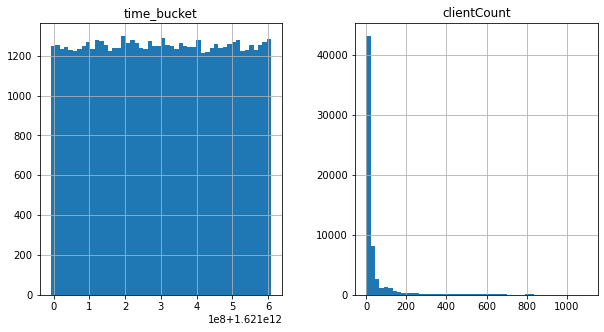

In [7]:
strat_train_set.hist(bins=50, figsize=(10,5))
plt.show()

## Discover data

In [8]:
print(set(strat_train_set["building"].values))

{'08-BK-City', '61-Vliegtuighal', '25-GreenVillage', '36-EWI-HB', '62-LR', '45-LSL', 'Unknown', 'Katalyse Labaratorium', '20-Aula', '36-ESP-Lab', '64-HSL', '60-LMS', '38-Cultureel Centrum', '34-3ME', '37-Sportcentrum', '63-Simona', '22-TNW-TN', '58-TNW-Zuid', '33-Pulse', '66-Fellowship', '30-O S', '32-OCP-IO', '30-IKC_ISD-FMVG', '05-TNW-BIO', '46-P E lab', '19-Studuitzendbureau', '28- WNI', '31-TBM', '35-Drebbelweg', '32a- Learninglab', '23-CITG', 'VLL-LAB(TNO)', '50-TNW-RID', '36-EWI LB_K t/m 3 & HB_K  t/m 2e ', '43-EGM', '26-Bouwcampus', '21-BTUD', '03-Science Center'}


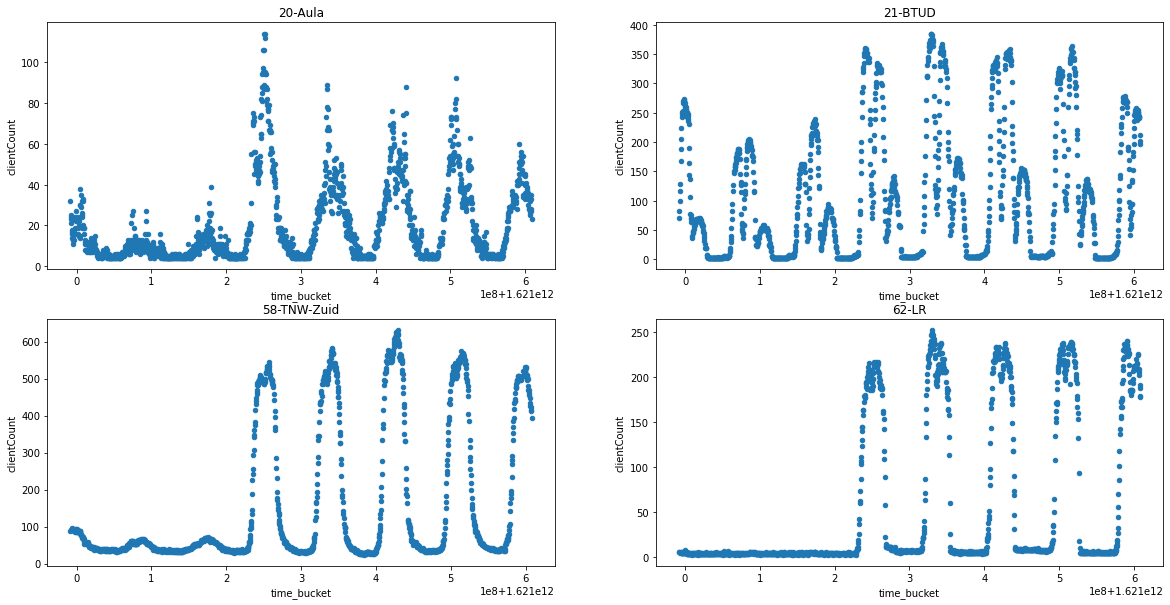

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2)

strat_train_set.loc[strat_train_set["building"] == "20-Aula"].plot(kind="scatter", x="time_bucket", y="clientCount", figsize=(20,10), ax=axes[0,0]).set_title("20-Aula")
strat_train_set.loc[strat_train_set["building"] == "21-BTUD"].plot(kind="scatter", x="time_bucket", y="clientCount", figsize=(20,10), ax=axes[0,1]).set_title("21-BTUD")
strat_train_set.loc[strat_train_set["building"] == "58-TNW-Zuid"].plot(kind="scatter", x="time_bucket", y="clientCount", figsize=(20,10), ax=axes[1,0]).set_title("58-TNW-Zuid")
strat_train_set.loc[strat_train_set["building"] == "62-LR"].plot(kind="scatter", x="time_bucket", y="clientCount", figsize=(20,10), ax=axes[1,1]).set_title("62-LR")

plt.show()

## Looking for Correlations

In [10]:
corr_matrix = strat_train_set.corr()
corr_matrix["clientCount"].sort_values(ascending=False)

clientCount    1.000000
time_bucket    0.187621
Name: clientCount, dtype: float64

array([[<AxesSubplot:xlabel='clientCount', ylabel='clientCount'>,
        <AxesSubplot:xlabel='time_bucket', ylabel='clientCount'>],
       [<AxesSubplot:xlabel='clientCount', ylabel='time_bucket'>,
        <AxesSubplot:xlabel='time_bucket', ylabel='time_bucket'>]],
      dtype=object)

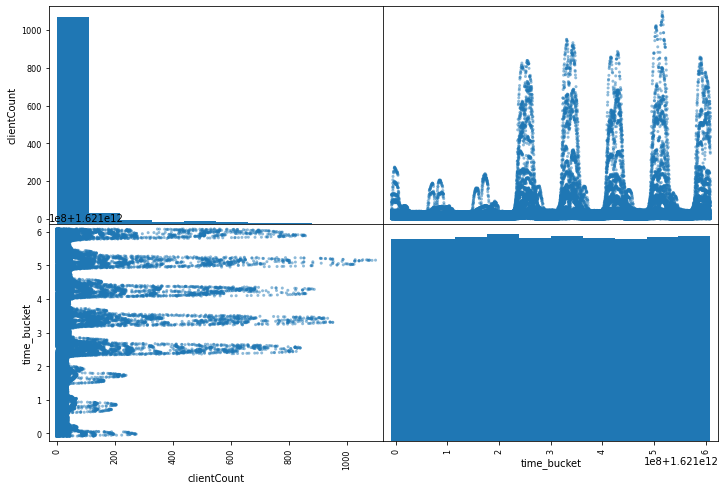

In [11]:
# this helped a lot: https://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html#targeting-different-subplots
attributes = ["clientCount", "time_bucket"]
pd.plotting.scatter_matrix(strat_train_set[attributes], figsize=(12,8))

## Expermiment with attributes

In [12]:
exp_attrib = strat_train_set.copy()
exp_attrib["day_of_week"] = exp_attrib["time_bucket"].apply(lambda d: datetime.datetime.fromtimestamp(d/1000).weekday())
exp_attrib["time_of_day"] = exp_attrib["time_bucket"].apply(lambda d: int(d%86400000))
exp_attrib["building_no"] = exp_attrib["building"].apply(lambda d: int(d[:2]) if d[:2].isdigit() else 99)

print(exp_attrib["building_no"])

11688    37
61351    36
55780    66
26158    32
34879    64
         ..
50892    28
33498    36
4160     35
56082    63
55786     8
Name: building_no, Length: 62532, dtype: int64


In [13]:
corr_matrix = exp_attrib.corr()
corr_matrix["clientCount"].sort_values(ascending=False)

clientCount    1.000000
time_bucket    0.187621
time_of_day   -0.014102
building_no   -0.137779
day_of_week   -0.157771
Name: clientCount, dtype: float64

array([[<AxesSubplot:xlabel='clientCount', ylabel='clientCount'>,
        <AxesSubplot:xlabel='time_bucket', ylabel='clientCount'>,
        <AxesSubplot:xlabel='day_of_week', ylabel='clientCount'>,
        <AxesSubplot:xlabel='time_of_day', ylabel='clientCount'>,
        <AxesSubplot:xlabel='building_no', ylabel='clientCount'>],
       [<AxesSubplot:xlabel='clientCount', ylabel='time_bucket'>,
        <AxesSubplot:xlabel='time_bucket', ylabel='time_bucket'>,
        <AxesSubplot:xlabel='day_of_week', ylabel='time_bucket'>,
        <AxesSubplot:xlabel='time_of_day', ylabel='time_bucket'>,
        <AxesSubplot:xlabel='building_no', ylabel='time_bucket'>],
       [<AxesSubplot:xlabel='clientCount', ylabel='day_of_week'>,
        <AxesSubplot:xlabel='time_bucket', ylabel='day_of_week'>,
        <AxesSubplot:xlabel='day_of_week', ylabel='day_of_week'>,
        <AxesSubplot:xlabel='time_of_day', ylabel='day_of_week'>,
        <AxesSubplot:xlabel='building_no', ylabel='day_of_week'>],
       

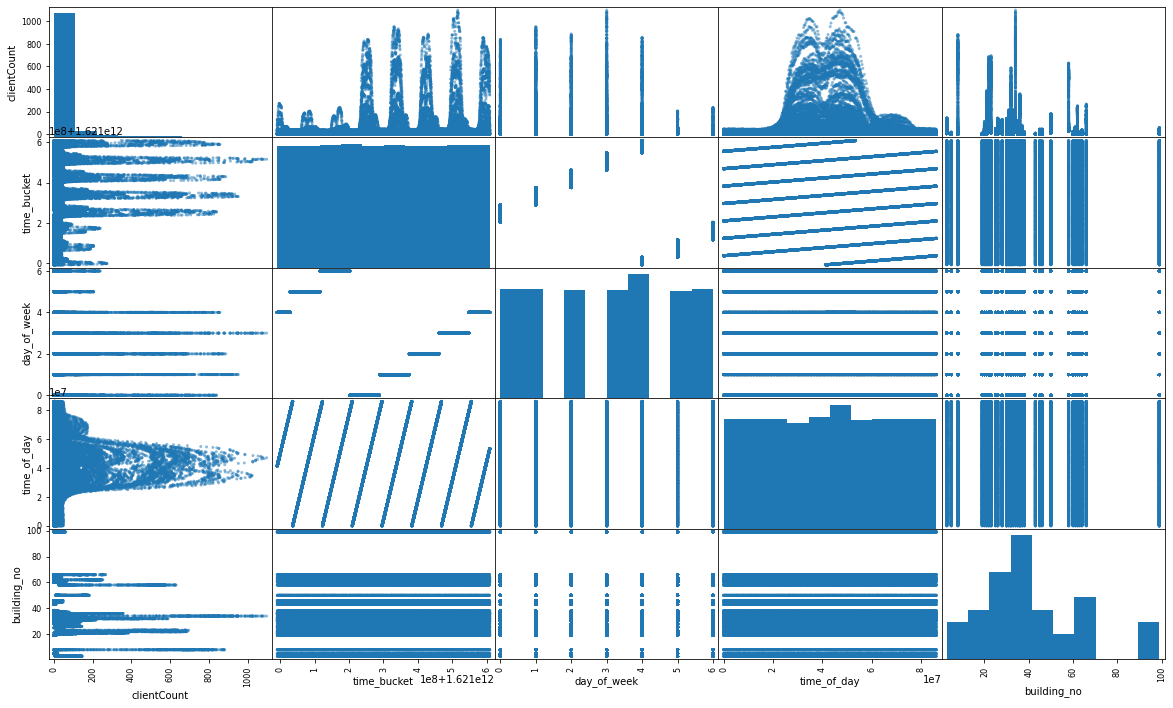

In [14]:
attributes = ["clientCount", "time_bucket", "day_of_week", "time_of_day", "building_no"]
pd.plotting.scatter_matrix(exp_attrib[attributes], figsize=(20,12))

## Create Work days and Student days

In [15]:
uni_hols = (datetime.date(year=2021, month=5, day=5),
            datetime.date(year=2021, month=5, day=13),
            datetime.date(year=2021, month=5, day=14),
            datetime.date(year=2021, month=5, day=24)
           )  # National Holidays and Collective Free days

def roster(date):
    # categorise the days of the academic year at TU Delft between 1 May 2021 and 29 August 2021
    
    if (date > datetime.date(year=2021, month=5, day=16)) and \
       (date < datetime.date(year=2021, month=5, day=22)):
        categorie = "Exam_BSc"
    elif (date > datetime.date(year=2021, month=6, day=15)) and \
         (date < datetime.date(year=2021, month=6, day=19)):
        categorie = "Study_mixed"
    elif (date > datetime.date(year=2021, month=6, day=22)) and \
         (date < datetime.date(year=2021, month=6, day=26)):
        categorie = "Exam_mixed"
    elif (date > datetime.date(year=2021, month=6, day=29)) and \
         (date < datetime.date(year=2021, month=7, day=3)):
        categorie = "Exam"
    elif (date > datetime.date(year=2021, month=8, day=8)) and \
         (date < datetime.date(year=2021, month=8, day=14)):
        categorie = "Exam"
    elif (date > datetime.date(year=2021, month=7, day=4)):
        categorie = "Free"
    else:
        categorie = "Learn"
    return categorie

In [16]:
exp_attrib["academic_yr"] = exp_attrib["time_bucket"].apply(lambda d: roster(datetime.datetime.fromtimestamp(d/1000).date()))
exp_attrib["uni_hols"] = exp_attrib["time_bucket"].apply(lambda d: 1 if datetime.datetime.fromtimestamp(d/1000).date() in uni_hols else 0)
exp_attrib["weekend"] = exp_attrib["day_of_week"].apply(lambda d: 1 if d > 4 else 0)

print(exp_attrib["uni_hols"])

11688    0
61351    0
55780    0
26158    0
34879    0
        ..
50892    0
33498    0
4160     1
56082    0
55786    0
Name: uni_hols, Length: 62532, dtype: int64


In [17]:
corr_matrix = exp_attrib.corr()
corr_matrix["clientCount"].sort_values(ascending=False)

clientCount    1.000000
time_bucket    0.187621
time_of_day   -0.014102
uni_hols      -0.062837
building_no   -0.137779
day_of_week   -0.157771
weekend       -0.182159
Name: clientCount, dtype: float64

array([[<AxesSubplot:xlabel='clientCount', ylabel='clientCount'>,
        <AxesSubplot:xlabel='weekend', ylabel='clientCount'>,
        <AxesSubplot:xlabel='day_of_week', ylabel='clientCount'>,
        <AxesSubplot:xlabel='building_no', ylabel='clientCount'>],
       [<AxesSubplot:xlabel='clientCount', ylabel='weekend'>,
        <AxesSubplot:xlabel='weekend', ylabel='weekend'>,
        <AxesSubplot:xlabel='day_of_week', ylabel='weekend'>,
        <AxesSubplot:xlabel='building_no', ylabel='weekend'>],
       [<AxesSubplot:xlabel='clientCount', ylabel='day_of_week'>,
        <AxesSubplot:xlabel='weekend', ylabel='day_of_week'>,
        <AxesSubplot:xlabel='day_of_week', ylabel='day_of_week'>,
        <AxesSubplot:xlabel='building_no', ylabel='day_of_week'>],
       [<AxesSubplot:xlabel='clientCount', ylabel='building_no'>,
        <AxesSubplot:xlabel='weekend', ylabel='building_no'>,
        <AxesSubplot:xlabel='day_of_week', ylabel='building_no'>,
        <AxesSubplot:xlabel='building_n

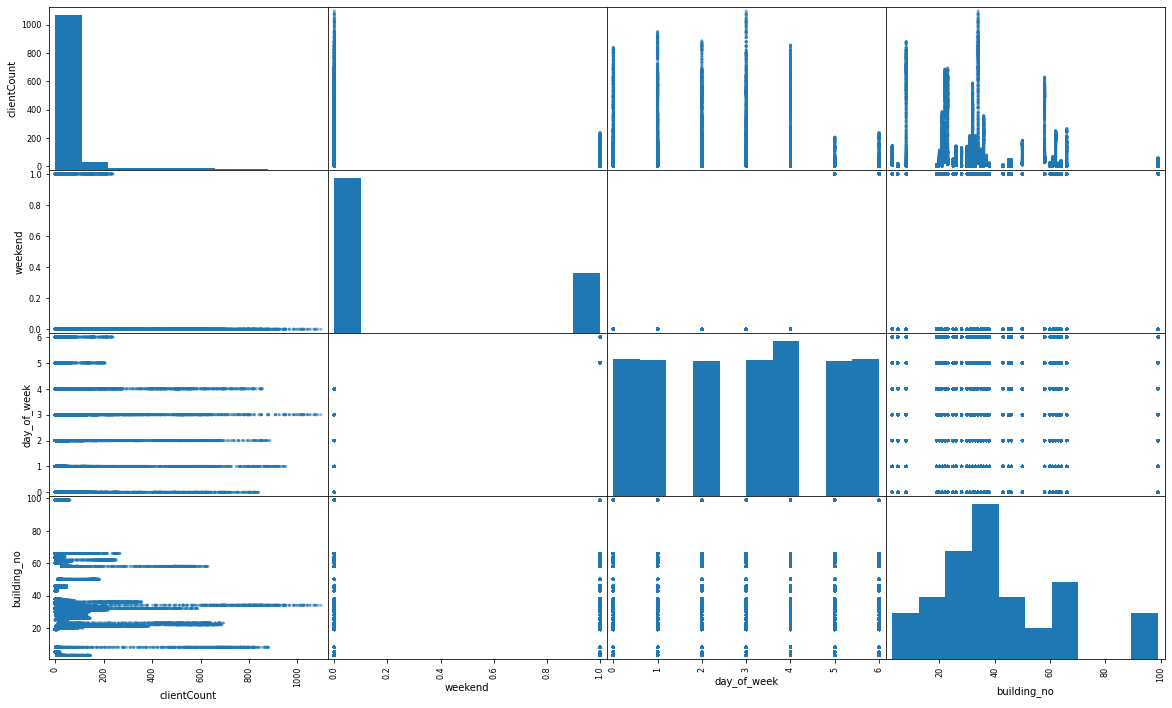

In [18]:
attributes = ["clientCount", "academic_yr", "weekend", "day_of_week", "building_no"]
pd.plotting.scatter_matrix(exp_attrib[attributes], figsize=(20,12))

## Definitely not according to the book

In [19]:
print(strat_train_set)

         time_bucket                           building  clientCount
11688  1621083900000                    37-Sportcentrum           15
61351  1621476000000                         36-ESP-Lab            1
55780  1621431900000                      66-Fellowship          101
26158  1621198200000                          32-OCP-IO           12
34879  1621266900000                             64-HSL           16
...              ...                                ...          ...
50892  1621393500000                            28- WNI            4
33498  1621256100000  36-EWI LB_K t/m 3 & HB_K  t/m 2e           247
4160   1621024500000                      35-Drebbelweg            2
56082  1621434300000                          63-Simona            8
55786  1621432200000                         08-BK-City          670

[62532 rows x 3 columns]


## Separate predictions and labels

In [20]:
crowd = strat_train_set.drop("clientCount", axis=1)
crowd_labels = strat_train_set["clientCount"].copy()
print(crowd)

         time_bucket                           building
11688  1621083900000                    37-Sportcentrum
61351  1621476000000                         36-ESP-Lab
55780  1621431900000                      66-Fellowship
26158  1621198200000                          32-OCP-IO
34879  1621266900000                             64-HSL
...              ...                                ...
50892  1621393500000                            28- WNI
33498  1621256100000  36-EWI LB_K t/m 3 & HB_K  t/m 2e 
4160   1621024500000                      35-Drebbelweg
56082  1621434300000                          63-Simona
55786  1621432200000                         08-BK-City

[62532 rows x 2 columns]


In [21]:
assert crowd.isnull().values.any() == False  # check there are no missing values

## Build Transformers

In [22]:
# separate out the numerical and the categorical attributes
cat_attribs = ["building"]
crowd_num = crowd.drop(cat_attribs, axis=1)
num_attribs = list(crowd_num)

In [23]:
class CombinedCatAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_academic_yr=True):
        self.add_academic_yr = add_academic_yr
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_np = X["building"].to_numpy()
        if self.add_academic_yr:
            time_of_day = X["time_bucket"].apply(lambda d: roster(datetime.datetime.fromtimestamp(d/1000).date()))
            X_np = np.c_[X_np, time_of_day]
        return X_np

In [24]:
class CombinedNumAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_day_of_week=True, add_time_of_day=True, add_uni_hols=True, add_weekend=True):
        self.add_day_of_week = add_day_of_week
        self.add_time_of_day = add_time_of_day
        self.add_uni_hols = add_uni_hols
        self.add_weekend = add_weekend
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_np = X.to_numpy()
        if self.add_day_of_week:
            day_of_week = X["time_bucket"].apply(lambda d: datetime.datetime.fromtimestamp(d/1000).weekday())
            X_np = np.c_[X_np, day_of_week]
        if self.add_time_of_day:
            time_of_day = X["time_bucket"].apply(lambda d: int(d%86400000))
            X_np = np.c_[X_np, time_of_day]
        if self.add_uni_hols:
            hols = X["time_bucket"].apply(lambda d: 1. if datetime.datetime.fromtimestamp(d/1000).date() in uni_hols else 0.)
            X_np = np.c_[X_np, hols]
        if self.add_weekend:
            weekend = X["time_bucket"].apply(lambda d: 1. if datetime.datetime.fromtimestamp(d/1000).weekday() > 4 else 0.)
            X_np = np.c_[X_np, weekend]
        return X_np

## Transformation pipeline including Feature scaling

In [25]:
# build a pipeline for the numerical attributes
num_pipeline = Pipeline([
    ('attribs_adder', CombinedNumAttributesAdder()),
    ('std_scaler', StandardScaler())
])

In [26]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),  # encode the buildings and accademic year categories to numbers
])

crowd_prepared = full_pipeline.fit_transform(crowd)  # this gives a sparse matrix!
print(crowd_prepared.toarray())
print(crowd_prepared.toarray().shape)

[[-1.21669404  0.9978856   0.16027025 ...  0.          0.
   0.        ]
 [ 0.98681612 -0.00801088 -1.45222465 ...  0.          0.
   0.        ]
 [ 0.73898445 -0.51095912  0.25726243 ...  0.          0.
   0.        ]
 ...
 [-1.55050812  0.49493736  1.25143222 ...  0.          0.
   0.        ]
 [ 0.75247189 -0.51095912  0.3542546  ...  0.          0.
   0.        ]
 [ 0.74067038 -0.51095912  0.26938645 ...  0.          0.
   0.        ]]
(62532, 43)


## Select and Train a model

In [32]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(crowd_prepared, crowd_labels)

LinearRegression()

In [28]:
# check out the predictions
some_data = crowd.iloc[:5]
some_labels = crowd_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [-6.37154415 20.54789305 56.39222008 86.51314654 31.05846817]
Labels: [15, 1, 101, 12, 16]


In [29]:
crowd_predictions = lin_reg.predict(crowd_prepared)
lin_mse = mean_squared_error(crowd_labels, crowd_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

97.30959112641592


In [34]:
lin_scores = cross_val_score(lin_reg, crowd_prepared, crowd_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 95.40334995  95.58231471  95.35683969  97.98275819 105.73822237
  92.31583887  97.21878147  98.41494308 100.75946891  94.76875369]
Mean: 97.35412709332496
Standard deviation: 3.5557101115716527


In [30]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(crowd_prepared, crowd_labels)

crowd_predictions = tree_reg.predict(crowd_prepared)
tree_mse = mean_squared_error(crowd_labels, crowd_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


In [31]:
scores = cross_val_score(tree_reg, crowd_prepared, crowd_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [33]:
display_scores(tree_rmse_scores)

Scores: [6.34434548 5.4207374  5.08554676 6.41041303 5.94855067 5.83270693
 5.60115533 5.49922577 5.81308351 5.67132448]
Mean: 5.7627089354368755
Standard deviation: 0.3845989247618384


In [36]:
forest_reg = RandomForestRegressor()
forest_reg.fit(crowd_prepared, crowd_labels)

crowd_predictions = forest_reg.predict(crowd_prepared)
forest_mse = mean_squared_error(crowd_labels, crowd_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

1.6726706293106575


#### This takes forever:
```
scores = cross_val_score(forest_reg, crowd_prepared, crowd_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

display_scores(forest_rmse_scores)
```

#### And gives:
```
Scores: [4.749643   4.76390659 4.30937237 4.522331   4.81781278 4.23193265
 4.41995539 4.33340377 4.82789383 4.82683287]
Mean: 4.580308424372585
Standard deviation: 0.22927539118401316
```

#### Save what we have so far:
```
from joblib import dump

dump(lin_reg, "lin_reg.joblib")
dump(tree_reg, "tree_reg.joblib")
dump(forest_reg, "forest_reg.joblib")
```